In [ ]:
from google.colab import files
uploaded = files.upload()

Saving movie.zip to movie.zip


Data:
                                 Name    Year Duration  \
0                                         NaN      NaN   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min   
2                         #Homecoming  (2021)   90 min   
3                             #Yaaram  (2019)  110 min   
4                   ...And Once Again  (2010)  105 min   
5                ...Aur Pyaar Ho Gaya  (1997)  147 min   
6                           ...Yahaan  (2005)  142 min   
7                      .in for Motion  (2008)   59 min   
8                  ?: A Question Mark  (2012)   82 min   
9                            @Andheri  (2014)  116 min   

                       Genre  Rating  Votes            Director  \
0                      Drama     NaN    NaN       J.S. Randhawa   
1                      Drama     7.0      8       Gaurav Bakshi   
2             Drama, Musical     NaN    NaN  Soumyajit Majumdar   
3            Comedy, Romance     4.4     35          Ovais Khan   
4                   

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Model Evaluation:
Mean Squared Error (MSE): 1.56
Mean Absolute Error (MAE): 0.99
R-squared (R2): 0.16

Predictions vs Actual:
       Predicted  Actual
9456    5.629608     3.3
14816   5.282743     5.3
3213    5.753207     5.7
3778    6.135507     7.2
5775    4.412160     3.5


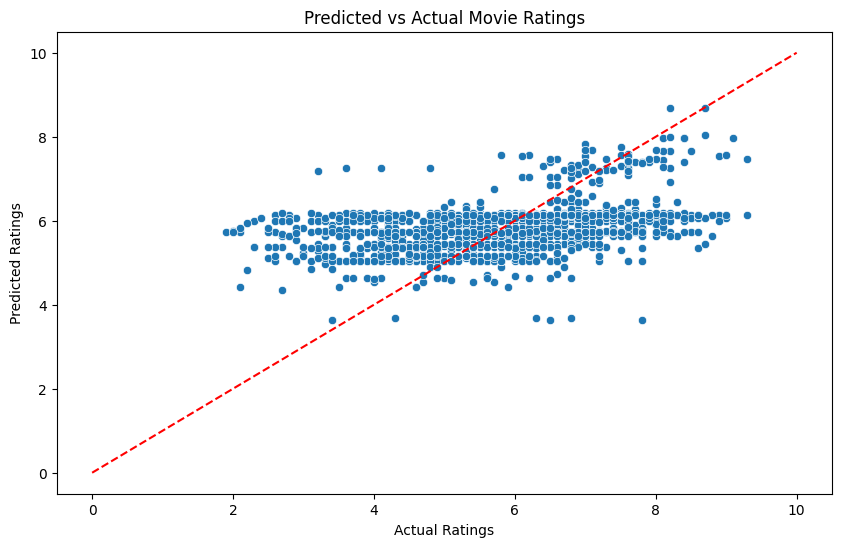

In [ ]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the movie.zip file
with zipfile.ZipFile('movie.zip', 'r') as zip_ref:
    zip_ref.extractall()  # This will extract to the current directory

# Load the extracted CSV file (assuming it's named IMDb Movies India.csv)
df = pd.read_csv('IMDb Movies India.csv', encoding='latin-1')

# Display the first few rows of the dataset
print("Data:")
print(df.head(10))

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Remove rows with missing ratings as they are essential for training
df = df.dropna(subset=['Rating'])

# Convert 'Votes' to a numeric type (removing commas)
df['Votes'] = df['Votes'].str.replace(',', '').astype(float)

# Fill missing values for 'Votes' with the median
df['Votes'].fillna(df['Votes'].median(), inplace=True)

# Extract the first genre for simplicity
df['Main Genre'] = df['Genre'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else x)

# Extract the first actor as the main actor for simplicity
df['Main Actor'] = df['Actor 1']

# Feature engineering: Calculate the total number of actors listed
df['Num Actors'] = df[['Actor 1', 'Actor 2', 'Actor 3']].notnull().sum(axis=1)

# Select features and target
X = df[['Main Genre', 'Director', 'Main Actor', 'Votes', 'Num Actors']]
y = df['Rating']

# Reduce the dataset size for faster computation if needed
# df = df.sample(frac=0.5, random_state=42)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('genre', OneHotEncoder(handle_unknown='ignore', sparse=False), ['Main Genre']),
        ('director', OneHotEncoder(handle_unknown='ignore', sparse=False), ['Director']),
        ('actor', OneHotEncoder(handle_unknown='ignore', sparse=False), ['Main Actor']),
        ('scaler', StandardScaler(), ['Votes', 'Num Actors'])
    ])

# Define the model pipeline using Random Forest Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Display predictions vs actual
print("\nPredictions vs Actual:")
results = pd.DataFrame({'Predicted': y_pred, 'Actual': y_test})
print(results.head())

# Visualize predictions vs actual ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results)
plt.title('Predicted vs Actual Movie Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([0, 10], [0, 10], 'r--')  # Line of perfect prediction
plt.show()
